<a href="https://colab.research.google.com/github/PrajjwalNakarmi/Artificial-Intelligence/blob/main/AirQualityIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import requests
import seaborn as sns

In [ ]:
url = "https://admin.opendatanepal.com/api/action/datastore_search"

resource_id = "ad8d1b4d-7667-455d-ab74-d5966e8ba4c3"

all_records = []
offset = 0
limit = 1000

while True:
    params = {
        "resource_id": resource_id,
        "sort": "_id asc",
        "limit": limit,
        "offset": offset
    }

    response = requests.get(url, params=params)
    data = response.json()

    records = data["result"]["records"]
    all_records.extend(records)

    if len(records) < limit:
        break

    offset += limit

df = pd.DataFrame(all_records)

print("Total records fetched:", len(df))
print(df.head())


Total records fetched: 60779
   _id locationId                               location       city country  \
0    1       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
1    2       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
2    3       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
3    4       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   
4    5       3459  US Diplomatic Post: Embassy Kathmandu  Kathmandu      NP   

                         utc                      local parameter  value  \
0  2021-03-12T18:15:00+00:00  2021-03-13T00:00:00+05:45        o3  0.057   
1  2021-03-12T18:15:00+00:00  2021-03-13T00:00:00+05:45      pm25     50   
2  2021-03-12T17:15:00+00:00  2021-03-12T23:00:00+05:45      pm25     46   
3  2021-03-12T17:15:00+00:00  2021-03-12T23:00:00+05:45        o3  0.051   
4  2021-03-12T16:15:00+00:00  2021-03-12T22:00:00+05:45      pm25     45   

    unit   latitude  longitude  
0    p

In [ ]:
print(df.columns)

Index(['_id', 'locationId', 'location', 'city', 'country', 'utc', 'local',
       'parameter', 'value', 'unit', 'latitude', 'longitude'],
      dtype='object')


In [ ]:
# Keeping only relevant columns
df1 = df[['utc', 'parameter', 'value']]

print(df1.head())


                         utc parameter  value
0  2021-03-12T18:15:00+00:00        o3  0.057
1  2021-03-12T18:15:00+00:00      pm25     50
2  2021-03-12T17:15:00+00:00      pm25     46
3  2021-03-12T17:15:00+00:00        o3  0.051
4  2021-03-12T16:15:00+00:00      pm25     45


In [ ]:
df.to_csv("airquality.csv", index=False)
print("Dataset saved as airquality.csv")


Dataset saved as airquality.csv


In [ ]:
# Convert value column to numeric (VERY IMPORTANT)
df1['value'] = pd.to_numeric(df1['value'], errors='coerce')

# Drop rows where conversion failed
df1 = df1.dropna(subset=['value'])

print(df1.dtypes)



utc           object
parameter     object
value        float64
dtype: object


/tmp/ipython-input-2841233841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['value'] = pd.to_numeric(df1['value'], errors='coerce')


In [ ]:
# Convert long → wide format
df2 = df1.pivot_table(
    index='utc',
    columns='parameter',
    values='value',
    aggfunc='mean'
).reset_index()

print(df2.head())
print(df2.columns)

parameter                        utc     o3   pm25
0          2017-03-02T23:15:00+00:00  0.004   54.5
1          2017-03-03T00:15:00+00:00  0.004   73.3
2          2017-03-03T01:15:00+00:00  0.003   76.1
3          2017-03-03T02:15:00+00:00  0.005   95.0
4          2017-03-03T03:15:00+00:00  0.009  208.5
Index(['utc', 'o3', 'pm25'], dtype='object', name='parameter')


In [ ]:
df_labeled = df2.copy()

def classify_air_quality(pm25):
    if pm25 <= 50:
        return 'Good'
    elif pm25 <= 100:
        return 'Moderate'
    else:
        return 'Poor'

df_labeled['air_quality'] = df_labeled['pm25'].apply(classify_air_quality)

print(df_labeled['air_quality'].value_counts())


air_quality
Good        22100
Moderate     6917
Poor         3222
Name: count, dtype: int64


In [ ]:
#This Code was written first taking both pm2.5 and o3 features and models each gave 1.0 and 0.99 accuracy.
#The classification labels were generated using PM2.5 threshold rules, and PM2.5 was included as a feature.
#Decision Tree and Random Forest models can perfectly learn these rules, which resulted in 100% accuracy.
#This indicates rule learning rather than model generalization.

# Select features that actually exist
#features = [col for col in ['pm25', 'pm10', 'o3'] if col in df2.columns]

#df_model = df2[features].dropna()

#print("Features used:", features)
#print(df_model.head())



In [ ]:
features = ['o3']  # NO pm25, NO pm10 that is why these were removed

df_model = df_labeled[features + ['air_quality']].dropna()

print(df_model.head())


parameter     o3 air_quality
0          0.004    Moderate
1          0.004    Moderate
2          0.003    Moderate
3          0.005    Moderate
4          0.009        Poor


In [ ]:
X = df_model[features]
y = df_model['air_quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)

dt_pred = dt.predict(X_test_scaled)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.6821969052882163
              precision    recall  f1-score   support

        Good       0.69      0.98      0.81      3953
    Moderate       0.49      0.12      0.19      1303
        Poor       0.00      0.00      0.00       625

    accuracy                           0.68      5881
   macro avg       0.39      0.37      0.33      5881
weighted avg       0.57      0.68      0.59      5881



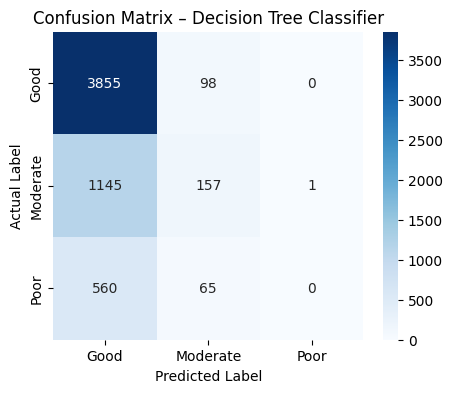

In [ ]:
def plot_confusion_matrix(y_true, dt_pred, title):
    cm = confusion_matrix(y_true, dt_pred, labels=labels)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(y_test,dt_pred,"Confusion Matrix – Decision Tree Classifier")

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.6820268661792213
              precision    recall  f1-score   support

        Good       0.69      0.98      0.81      3953
    Moderate       0.49      0.12      0.19      1303
        Poor       0.00      0.00      0.00       625

    accuracy                           0.68      5881
   macro avg       0.39      0.36      0.33      5881
weighted avg       0.57      0.68      0.59      5881



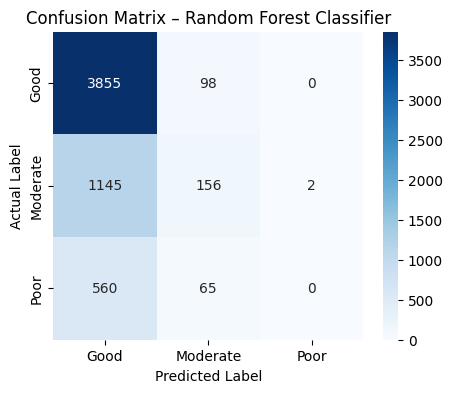

In [ ]:
def plot_confusion_matrix(y_true, rf_pred, title):
    cm = confusion_matrix(y_true, rf_pred, labels=labels)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(y_test,rf_pred,"Confusion Matrix – Random Forest Classifier")

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

KNN Accuracy: 0.6255738819928583
              precision    recall  f1-score   support

        Good       0.70      0.86      0.77      3953
    Moderate       0.27      0.14      0.18      1303
        Poor       0.25      0.15      0.18       625

    accuracy                           0.63      5881
   macro avg       0.41      0.38      0.38      5881
weighted avg       0.56      0.63      0.58      5881



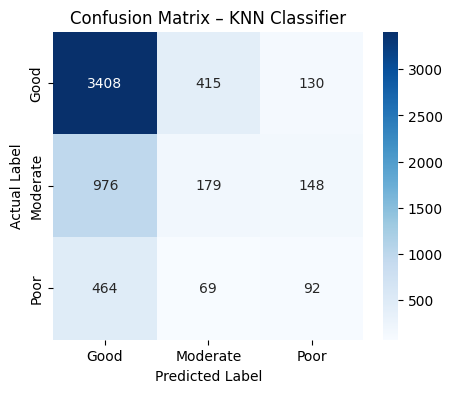

In [ ]:
def plot_confusion_matrix(y_true, knn_pred, title):
    cm = confusion_matrix(y_true, knn_pred, labels=labels)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(y_test,knn_pred,"Confusion Matrix – KNN Classifier")

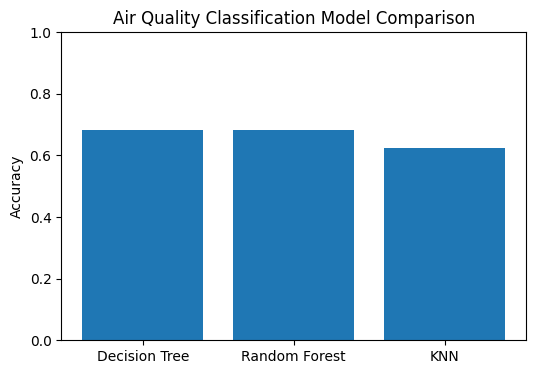

In [ ]:
models = ['Decision Tree', 'Random Forest', 'KNN']
accuracies = [
    accuracy_score(y_test, dt_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, knn_pred)
]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Air Quality Classification Model Comparison")
plt.ylim(0,1)
plt.show()

# Model in action

In [ ]:
new_sample = np.array([[0.055]])

# Scale the input using trained scaler
new_sample_scaled = scaler.transform(new_sample)

# Predict air quality using trained Random Forest model
prediction = knn.predict(new_sample_scaled)

print("Predicted Air Quality:", prediction[0])


Predicted Air Quality: Good


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
